In [123]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from DataTidy import json_reader, read_a_season, read_seasons, read_all_game

from joblib import dump, load

In [105]:
experiment = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/4aadc5f7d8dd4fbdb0d667838a440bea



In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016, 2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

100%|██████████| 6433/6433 [00:53<00:00, 119.24it/s]  


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [125]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df =train_val_df .sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df .reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:00<00:00,  4.50file/s]


In [126]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength,rink_side,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN,left,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN,left,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN,right,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,NaN,NaN,right,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN,right,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,NaN,NaN,right,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,NaN,NaN,left,19.983107,0


In [127]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

In [162]:
train_df, val_df = train_test_split(train_val_df, test_size=0.25,random_state=0)

### 1. Train with only **Distance** and **Angle**

#### 1.1 Training and Validating

In [163]:
train_df_1 = train_df[['shot_dist','angle_net','is_goal']]
val_df_1 = val_df[['shot_dist','angle_net','is_goal']]
train_df_1=train_df_1.dropna()
val_df_1=val_df_1.dropna()

In [164]:
train_X_1 = train_df_1[['shot_dist','angle_net']]
val_X_1 =  val_df_1[['shot_dist','angle_net']]
train_Y = train_df_1[['is_goal']]
val_Y =  val_df_1[['is_goal']]
train_X_1

,shot_dist,angle_net
317091,33.421550,-51.000000
58315,10.295630,29.054604
279578,10.295630,-60.000000
283640,147.013605,0.000000
17071,57.008771,21.614779
...,...,...
122579,55.081757,-15.000000
304137,40.459857,-39.000000
152315,55.326305,-6.000000
117952,31.953091,-20.000000


In [165]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [166]:
dump(xgboost1,'./xgboost1.joblib')


['./xgboost1.joblib']

In [167]:
train_y_hat = xgboost1.predict(train_X_1)
train_acc = metrics.accuracy_score(train_Y,train_y_hat)
print(f"Training Accuracy is {train_acc}")
# experiment.log_metric("train_acc",train_acc)

Training Accuracy is 0.9078101265822784


In [168]:
val_y_hat = xgboost1.predict(val_X_1)
val_acc = metrics.accuracy_score(val_Y,val_y_hat)
print(f"Validation Accuracy is {val_acc}")
# experiment.log_metric("val_acc",val_acc)

Validation Accuracy is 0.9067602315477472


# Discuss : TODO

#### 1.2

In [169]:
val_res = xgboost1.predict_proba(val_X_1)

##### ROC AUC

In [170]:
fpr,tpr,threshold = metrics.roc_curve(val_Y,val_res[:,1])

In [171]:
metrics.auc(fpr,tpr)

0.7073811059273122

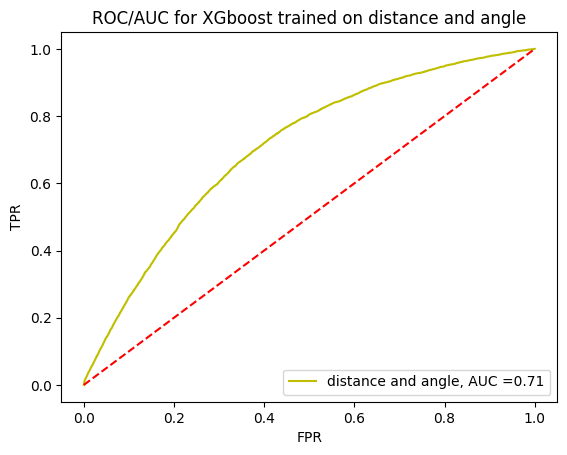

In [172]:
plt.title('ROC/AUC for XGboost trained on distance and angle')
plt.plot(fpr,tpr,'y',label="distance and angle, AUC =%0.2f"%metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc="lower right")


##### Goal rate

In [173]:
probas_and_label = val_Y.copy()

In [174]:
probas_and_label['goal_proba']=val_res[:,1]

In [175]:
probas_and_label

,is_goal,goal_proba
248541,0,0.116089
111574,1,0.152514
150403,1,0.172216
73604,0,0.008252
140849,0,0.011274
...,...,...
115009,0,0.036144
258418,0,0.061953
210896,0,0.035349
29997,0,0.005688


In [176]:
probas_and_label = probas_and_label.sort_values(by=['goal_proba'], ascending=False)

In [177]:
probas_and_label['#goal+#shot'] = range(1,len(probas_and_label)+1)

In [178]:
shot_and_goal = np.array(probas_and_label.loc[:,'is_goal'])
shot_and_goal

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [179]:
goal = np.zeros(len(shot_and_goal))

for i in range(len(shot_and_goal)):
    goal[i] = shot_and_goal[:i].sum()

In [180]:
probas_and_label['#goal'] =  goal

In [181]:
probas_and_label['#goal/#goal+#shot'] = 100*probas_and_label['#goal']/probas_and_label['#goal+#shot']
probas_and_label['rank'] = probas_and_label['goal_proba'].rank(pct=True)*100
probas_and_label['goal_prob_sum'] = probas_and_label['#goal/#goal+#shot'].sum()
probas_and_label['goal_prob_cumulative_sum'] = probas_and_label['#goal/#goal+#shot'].cumsum()
probas_and_label['cum_percent'] = 100*(probas_and_label['goal_prob_cumulative_sum'] / probas_and_label['goal_prob_sum'])

In [188]:
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
324045,0,0.695388,1,0.0,0.000000,99.996200,1.212003e+06,0.000000e+00,0.000000
83169,0,0.695388,2,0.0,0.000000,99.996200,1.212003e+06,0.000000e+00,0.000000
219038,0,0.695388,3,0.0,0.000000,99.996200,1.212003e+06,0.000000e+00,0.000000
257691,1,0.695388,4,0.0,0.000000,99.996200,1.212003e+06,0.000000e+00,0.000000
224489,0,0.695388,5,1.0,20.000000,99.996200,1.212003e+06,2.000000e+01,0.001650
...,...,...,...,...,...,...,...,...,...
18176,0,0.001595,78943,7363.0,9.326983,0.004433,1.212003e+06,1.211966e+06,99.996922
319056,0,0.001595,78944,7363.0,9.326865,0.004433,1.212003e+06,1.211975e+06,99.997691
163057,0,0.001595,78945,7363.0,9.326746,0.004433,1.212003e+06,1.211985e+06,99.998461
63459,1,0.001595,78946,7363.0,9.326628,0.004433,1.212003e+06,1.211994e+06,99.999230


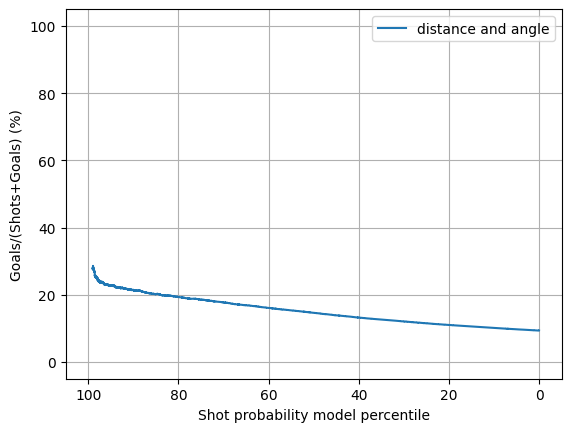

In [184]:
plt.plot(probas_and_label['rank'].iloc[int(len(probas_and_label)*0.01):],probas_and_label['#goal/#goal+#shot'].iloc[int(len(probas_and_label)*0.01):],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

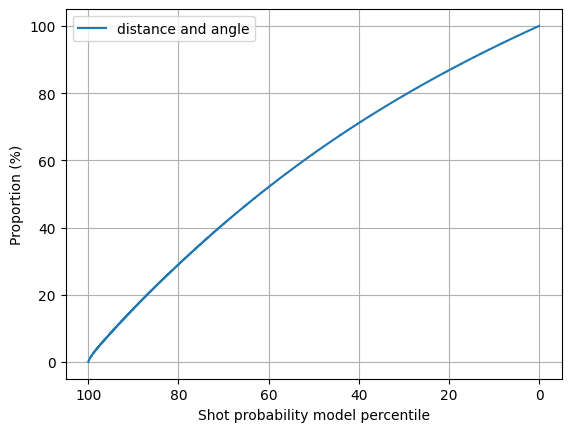

In [185]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

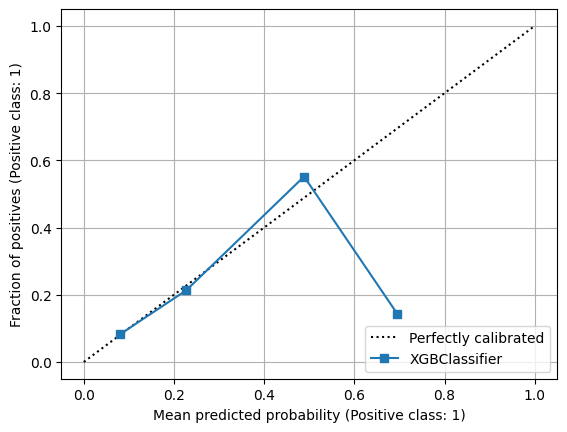

In [186]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y)
plt.grid(True)